# Pareto-NBD model

Comparison with lifetimes



#### References:
----------
David C. Schmittlein, Donald G. Morrison and Richard Colombo
Management Science,Vol. 33, No. 1 (Jan., 1987), pp. 1-24
"Counting Your Customers: Who Are They and What Will They Do Next,"
    
Fader, Peter & G. S. Hardie, Bruce (2005).
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](http://brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In [13]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import numpy as np
import warnings
from scipy.special import gamma, gammaln

# Extra dependencies for this notebook
from lifetimes.datasets import load_cdnow_summary
from lifetimes import ParetoNBDFitter

from pymc_marketing.clv.distributions import ParetoNBD

## Load data

In [31]:
df = load_cdnow_summary()
df

,ID,frequency,recency,T
0,1,2,30.43,38.86
1,2,1,1.71,38.86
2,3,0,0.00,38.86
3,4,0,0.00,38.86
4,5,0,0.00,38.86
...,...,...,...,...
2352,2353,0,0.00,27.00
2353,2354,5,24.29,27.00
2354,2355,0,0.00,27.00
2355,2356,4,26.57,27.00


In [15]:
df.shape

(2357, 5)

In [16]:
x = df["frequency"].values
t_x = df["recency"].values
T = df["T"].values

## Lifetimes implementation

In [21]:
pnbd = ParetoNBDFitter()

pnbd.params_ = {
            "r": 0.5534,
            "alpha": 10.5802,
            "s": 0.6061,
            "beta": 11.6562,
        }

# pnbd.params_ = pd.Series(
#             *([0.5534, 10.5802, 0.6061, 11.6562], ["r", "alpha", "s", "beta"])
#         )
#p_alive = 
pnbd.conditional_probability_alive(26.00, 30.86, 31.00)
pnbd.conditional_probability_alive(2, 30.43, 38.86)


0.8691106439681371

In [6]:
pf.conditional_probability_alive(
            frequency=2,
            recency=30.43,
            T=38.86
)

# pf.conditional_probability_alive(
#             frequency=x,
#             recency=t_x,
#             T=T
# ).mean()

0.8691130342358349

In [34]:
x = np.array([0,1,2])
x.size

pd.Series(1).size

1

In [7]:
fit = {"r": 0.55, "alpha": 10.58, "s": 0.61, "beta": 11.67}

ParetoNBDFitter._conditional_log_likelihood(list(fit.values()), x, t_x, T).sum()

-9595.008530490335

## PyMC-Marketing Implementation

Probability Alive Estimation

In [9]:
# r = 0.55
# alpha = 10.58
# s = 0.61
# beta = 11.67
# loglike = -9.56198126

r = 0.5534
alpha = 10.5802
s = 0.6061
beta = 11.6562
# loglike = -9.55451069

frequency=2
recency=30.43
T=38.86

# frequency=26
# recency=30.86
# T=31

#np.stack((t_x, x), axis=1).shape

# Check that likelihood matches that of lifetimes
pareto_dist = ParetoNBD.dist(r,alpha,s,beta,T)
values = np.stack((recency, frequency)) 
loglike = pm.logp(pareto_dist, values).eval()

loglike

np.stack((t_x, x), axis=1)

array([[30.43,  2.  ],
       [ 1.71,  1.  ],
       [ 0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ],
       [26.57,  4.  ],
       [ 0.  ,  0.  ]])

In [11]:
# should equal 0.869118658345502
from numpy import log, exp

# term1 = gamma(r+frequency)/gamma(r)
# term2 = (alpha/(alpha+T))**r
# term3 = (1/(alpha+T))**frequency
# term4 = (beta/(beta+T))**s

#term1*term2*term3*term4 = 6.109554972572686e-05

term1 = gammaln(r + frequency) - gammaln(r)
term2 = r * log(alpha / (alpha + T))
term3 = -frequency * log(alpha + T)
term4 = s * log(beta / (beta + T))
         
prob_alive = exp(term1+term2+term3+term4 - loglike)
prob_alive.mean()

# def test_conditional_probability_alive(self, cdnow):
#         """
#         Target taken from page 8,
#         https://cran.r-project.org/web/packages/BTYD/vignettes/BTYD-walkthrough.pdf
#         """
#         ptf = lt.ParetoNBDFitter()
#         ptf.params_ = pd.Series(
#             *([0.5534, 10.5802, 0.6061, 11.6562], ["r", "alpha", "s", "beta"])
#         )
#         p_alive = ptf.conditional_probability_alive(26.00, 30.86, 31.00)
#         assert abs(p_alive - 0.9979) < 0.001

0.8691106439681368

In [15]:
with pm.Model() as m1:
    r = pm.Weibull("r",alpha=10,beta=1)
    alpha = pm.Weibull("alpha",alpha=10,beta=10)
    s = pm.Weibull("s",alpha=10,beta=1)
    beta = pm.Weibull("beta",alpha=10,beta=10)
    llike = ParetoNBD("llike", r=r, alpha=alpha, s=s, beta=beta, T=T, observed=np.stack((t_x, x), axis=1))

In [16]:
r = 0.55
alpha = 10.58
s = 0.61
beta = 11.67

frequency=2
recency=30.43
T=38.86

value = [freq,rec]

T = 30
with pm.Model():
    pareto_nbd = distributions.ParetoNBD("pareto_nbd", r=r, alpha=alpha, s=s, beta=beta, T=T)
    
pm.logp(pareto_nbd, [freq,rec]).eval()

NameError: name 'distributions' is not defined

In [13]:
# with m1:
#     with warnings.catch_warnings():
#         warnings.filterwarnings(
#             action='ignore',
#             category=UserWarning,
#             message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
#         )   
        
#         warnings.filterwarnings(
#             action='ignore',
#             category=UserWarning,
#             message='Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
#         )   
        
#         idata = pm.sample(initvals=fit)  # jitter leads to points where gradient does not converge, takes ages to sample
#         idata = pm.sample(initvals=fit, init="adapt_diag")  # still takes ages to sample

# Test Alternative Probability Alive

In [ ]:
r_ = 0.55
alpha = 10.58
s = 0.61
beta = 11.67

loglike = pm.logp(llike, np.stack((t_x, x), axis=1)).sum().eval(dict(zip((r, alpha, s, beta), fit.values())))

        term1 = gammaln(r + x) - gammaln(r)
        term2 = r * log(alpha /(alpha + T))
        term3 = - x * log(alpha + T)
        term4 = s * log(beta / (beta + T + t))

        prob_alive = exp(term1+term2+term3+term4) / loglike

In [71]:
with pm.Model() as m2:
    r = pm.HalfFlat("r")
    alpha = pm.HalfFlat("alpha")
    s = pm.HalfFlat("s")
    beta = pm.HalfFlat("beta")
    
    purchase_rate_prior = pm.Gamma(name="purchase_rate", alpha=r, beta=alpha)
    churn_prior = pm.Gamma(name="churn", alpha=s, beta=beta)
    
    T_ = pm.MutableData(name="T", value=T)
    
    pm.Potential("likelihood",logp(np.stack((t_x, x),axis=1),purchase_rate_prior,churn_prior,T_))

In [72]:
with m2:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )        
        
        #idata2 = pm.sample(initvals=fit, step=pm.Slice())
        res2 = pm.find_MAP()
        # Twice as fast!

In [73]:
fit = {"r": 0.55, "alpha": 10.58, "s": 0.61, "beta": 11.67}

{k: res2[k] for k in fit}

{'r': array(7.654207e+13),
 'alpha': array(1.02638448e+15),
 's': array(8.5296412e+13),
 'beta': array(1.45886079e+15)}

In [24]:
with m1:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )        
        
        idata1 = pm.sample()#initvals=fit, step=pm.Slice())
        #res1 = pm.find_MAP()

/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.

/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/pytensor/scalar/math.py:1615: RuntimeWarning: overflow encountered in exp
  g_current = log_g_old_sign * np.exp(log_g_old) * sign_zk
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/pytensor/scalar/math.py:1633: RuntimeWarning: Hyp2F1 does not meet convergence conditions with given arguments a=3.034533845720862, b=1.7092947015292457, c=4.034533845720862, z=1.0
  warnings.warn(
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/pytensor/scalar/math.py:1616: RuntimeWarning: overflow encountered in scalar add
  res += g_current
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/pytensor/scalar/math.py:1615: RuntimeWarning: overflow encountered in exp
  g_current = log_g_old_sign * np.exp(log_g_old) * sign_zk
/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/pytensor/scalar/math.py:1633: RuntimeWarning: Hyp2F1 does not meet convergence conditi

ValueError: Not enough samples to build a trace.

In [15]:
fit = {"r": 0.55, "alpha": 10.58, "s": 0.61, "beta": 11.67}

{k: res1[k] for k in fit}

{'r': array(0.57644307),
 'alpha': array(10.62331157),
 's': array(0.60073199),
 'beta': array(10.33609763)}

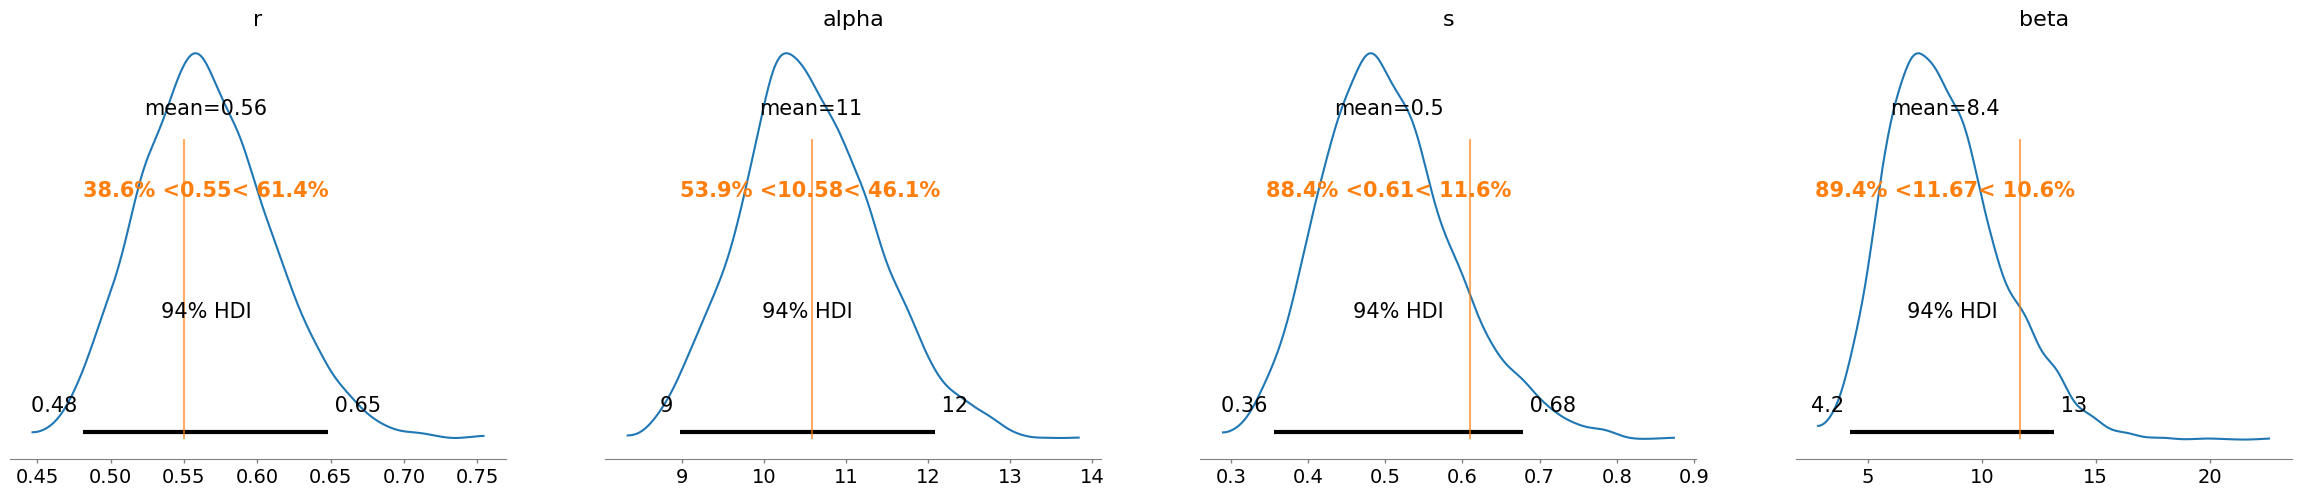

In [27]:
az.plot_posterior(idata1, ref_val=list(fit.values()));

IndexError: list index out of range

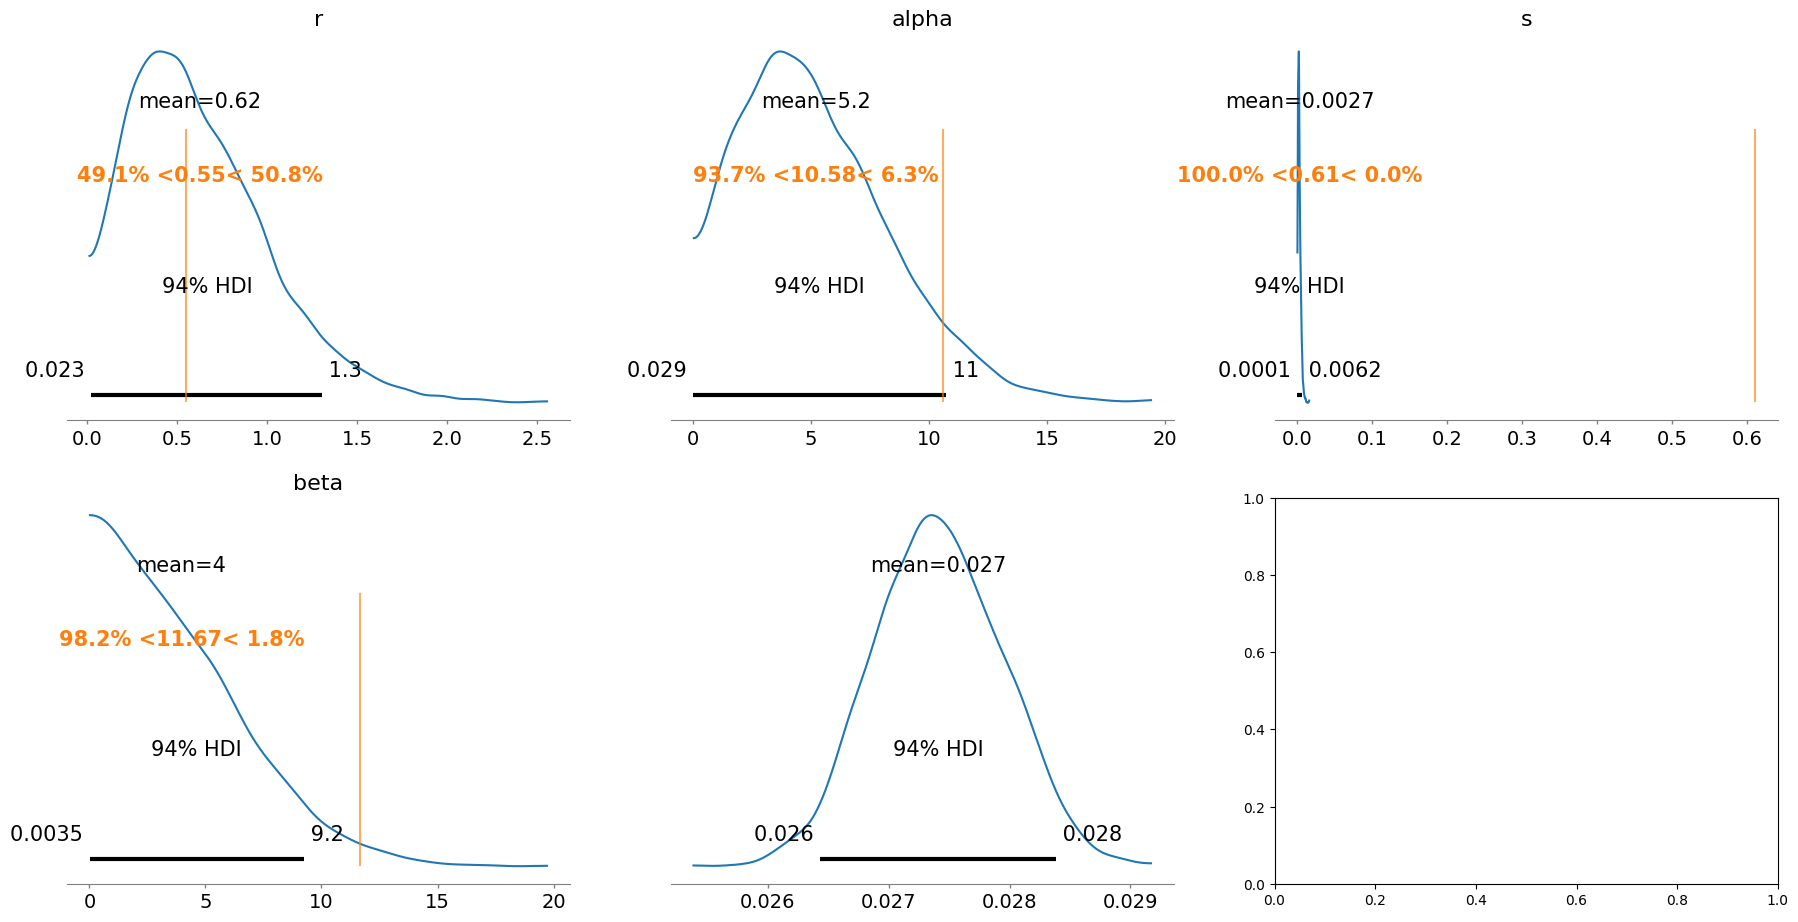

In [33]:
az.plot_posterior(idata2, ref_val=list(fit.values()));

## Drawing from distribution (4 times as much data)

In [16]:
fit

{'r': 0.55, 'alpha': 10.58, 's': 0.61, 'beta': 11.67}

In [17]:
draws = pm.draw(ParetoNBD.dist(**fit, T=T.mean(), size=10_000))
draws

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [30.31116197,  1.        ],
       ...,
       [ 0.        ,  0.        ],
       [24.10603648,  4.        ],
       [ 0.        ,  0.        ]])

In [18]:
draws.shape

(10000, 2)

In [19]:
with pm.Model() as m2:
    r = pm.HalfNormal("r")
    alpha = pm.HalfNormal("alpha", sigma=5)
    s = pm.HalfNormal("s")
    beta = pm.HalfNormal("beta", sigma=5)
    ParetoNBD("llike", r=r, alpha=alpha, s=s, beta=beta, T=T.mean(), observed=draws)

In [20]:
with m2:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )        
        
        idata = pm.sample(initvals=fit, step=pm.Slice())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [r]
>Slice: [alpha]
>Slice: [s]
>Slice: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 226 seconds.


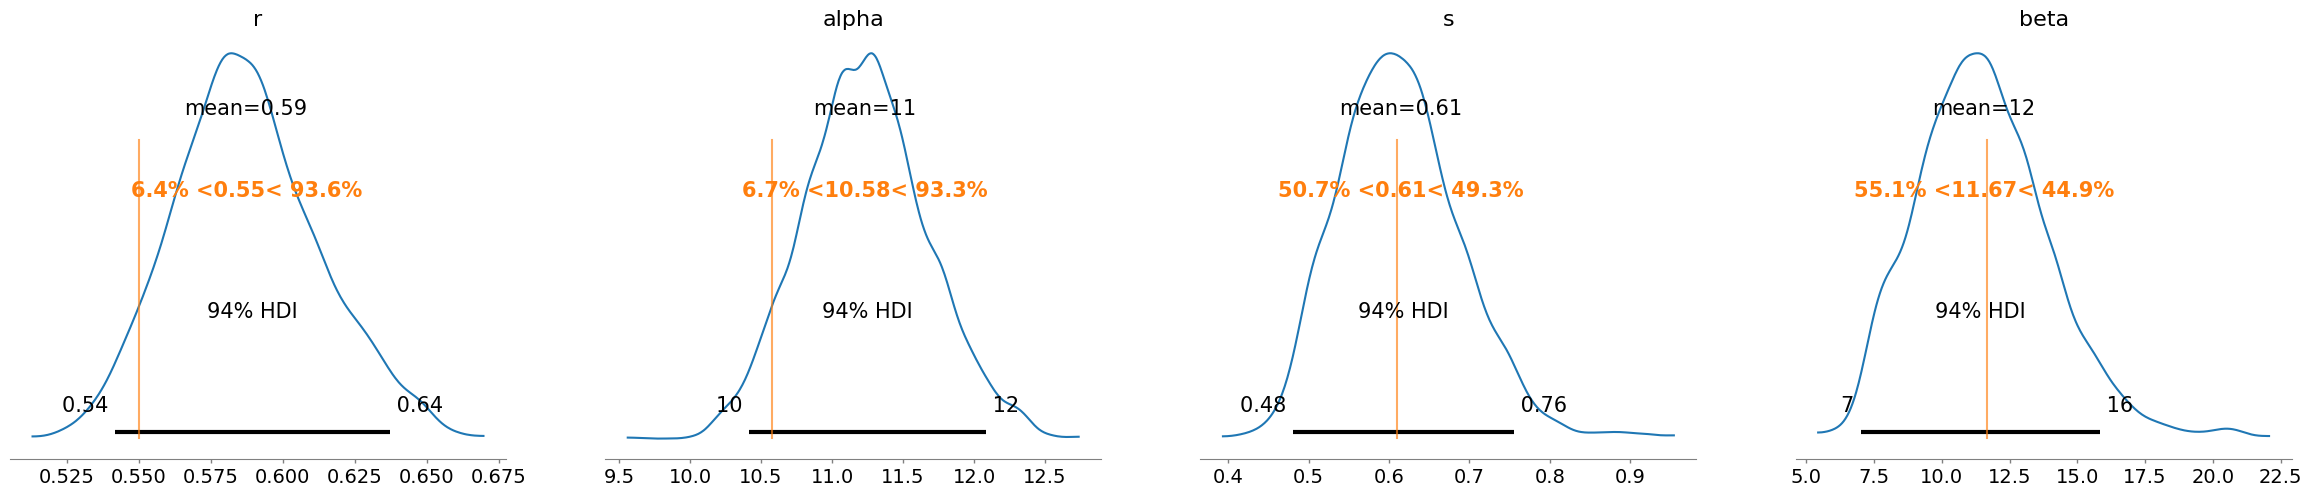

In [21]:
az.plot_posterior(idata, ref_val=list(fit.values()));

In [22]:
# with m2:
#     with warnings.catch_warnings():
#         warnings.filterwarnings(
#             action='ignore',
#             category=UserWarning,
#             message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
#         )   
        
#         warnings.filterwarnings(
#             action='ignore',
#             category=UserWarning,
#             message='Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
#         )   
        
#         idata = pm.sample(initvals=fit, init="adapt_diag")  # takes ages to sample

## Testing MAP

In [31]:
fit

{'r': 0.55, 'alpha': 10.58, 's': 0.61, 'beta': 11.67}

In [32]:
with m1:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )   
        
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )  
        res = pm.find_MAP()

In [33]:
{k: res[k] for k in fit}

{'r': array(0.56164462),
 'alpha': array(10.46574007),
 's': array(0.46757509),
 'beta': array(7.23078853)}

In [34]:
with m2:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )   
        
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )  
        res = pm.find_MAP()

In [35]:
{k: res[k] for k in fit}

{'r': array(0.58406664),
 'alpha': array(11.16349162),
 's': array(0.5909339),
 'beta': array(10.81945176)}